In [1]:
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

import statsmodels.api as sm
# from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from math import ceil

import re

import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
if not os.path.exists('active-dataset.p'):
    print('>>> Converting ACTIVE dataset from JSON format to pickle... might take a while!')
    active_videos = {}
    with bz2.BZ2File('active-dataset.json.bz2') as f:
        dataset = json.loads(f.readline())
    pickle.dump(dataset, open('active-dataset.p', 'wb'))
    
print('>>> Loading the ACTIVE dataset from pickle...')
active_videos = pickle.load(open('active-dataset.p', 'rb'))
df = pd.DataFrame(active_videos)

>>> Loading the ACTIVE dataset from pickle...


In [3]:
df.columns

Index(['YoutubeID', 'numTweet', 'numShare', 'numSubscriber', 'watchTime',
       'dailyViewcount', 'description', 'title', 'channelId', 'channelTitle',
       'category', 'uploadDate', 'duration', 'definition', 'dimension',
       'caption', 'regionRestriction.blocked', 'regionRestriction.allowed',
       'topicIds', 'relevantTopicIds', 'totalShare', 'totalViewcount',
       'totalTweet', 'dailyTweets'],
      dtype='object')

In [4]:
df.shape

(14041, 24)

In [5]:
df.head()

,YoutubeID,numTweet,numShare,numSubscriber,watchTime,dailyViewcount,description,title,channelId,channelTitle,...,dimension,caption,regionRestriction.blocked,regionRestriction.allowed,topicIds,relevantTopicIds,totalShare,totalViewcount,totalTweet,dailyTweets
0,00-6OyXVA0M,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[254, 1399, 493, 242, 175, 216, 372, 729, 305,...","[4, 19, 19, 7, 2, 5, 8, 17, 6, 3, 2, 1, 3, 1, ...","[59311.9833333, 455426.75, 206253.816667, 1119...","[90158, 695628, 312298, 170348, 82346, 61530, ...",Bill's response to Victoria Osteen's congregat...,Bill Cosby responds to Victoria Osteen,UCpzGw-b-rEPjRs2LT0ZVHTQ,Bryant Harris,...,2d,false,{},{},"[/m/03bxbhz, /m/03ny9x, /m/014zfs]",[/m/06bvp],5206,2174286,3857,"[2588, 455, 157, 100, 86, 76, 102, 64, 28, 23,..."
1,00ATf2HR-FA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[12, 47, 14, 32, 32, 12, 5, 4, 3, 4, 1, 0, 3, ...","[2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2937.13333333, 9039.33333333, 5082.71666667, ...","[14939, 40664, 21261, 30914, 31073, 20395, 117...",Adorable Cute South Korean Dog Gets Neck Massa...,Adorable Cute South Korean Dog Gets Neck Massage,UCT7HvytJiHm4BITiIQU1zwg,CloudSheep,...,2d,false,{},{},"[/m/0b_nd, /m/0bt9lr]",[/m/04h3kx],201,227149,189,"[75, 25, 18, 18, 15, 5, 10, 2, 0, 1, 2, 0, 1, ..."
2,00bumpN0Mhw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[583, 316, 178, 107, 92, 84, 135, 122, 133, 90...","[250, 146, 94, 51, 55, 54, 79, 63, 66, 51, 35,...","[235606.866667, 177160.183333, 133966.883333, ...","[89627, 63829, 46999, 42951, 42902, 36271, 416...","Download ""The Pressure"" on iTunes: http://smar...",Jhené Aiko - The Pressure (Explicit),UCkiXOKnkDO4qz3njQoz86LA,JheneAikoVEVO,...,2d,false,[DE],{},"[/m/011rvmhv, /m/0nhwg69]","[/m/011ccd35, /m/04rlf]",5878,2868185,4533,"[507, 227, 119, 88, 68, 77, 89, 74, 59, 41, 41..."
3,00f0ct78HcU,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[38, 11, 4, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[386, 194, 59, 16, 12, 5, 4, 2, 9, 5, 8, 9, 8,...","[119054.283333, 68698.1166667, 34243.9166667, ...","[91431, 52484, 26459, 14774, 7700, 5314, 4872,...",DON'T WANT TO MISS A PRANK? Subscribe here! \n...,Tank Explosion Accident!,UCuAcfy-GKYd1SPj8iEtA3Zw,Dudesons,...,2d,false,{},{},[/m/04cb12],"[/m/0bqb0z, /m/014zdl, /m/07cmd]",73,444387,192,"[39, 20, 5, 3, 4, 1, 2, 1, 2, 3, 2, 1, 0, 2, 0..."
4,00g2ZbI3ung,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[18, 3, 1, 1, 5, 5, 3, 2, 1, 1, 1, 0, 2, 1, 0,...","[63, 20, 5, 15, 19, 16, 18, 17, 12, 8, 12, 15,...","[11655.7333333, 3733.05, 2094.01666667, 1368.9...","[15512, 5027, 2691, 1861, 2563, 3891, 2751, 22...",These miracles will make you a god damn sexual...,Dark Souls II: Don't use hexes PSA,UCwPnX0XSfxswF0rL78NzNIw,veselekov,...,2d,false,{},{},"[/m/0p8xwrr, /m/0dgs3gt]","[/m/06zm8z, /m/02dpv4]",123,237425,186,"[60, 3, 1, 0, 1, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0,..."


In [6]:
df = df[['YoutubeID', 'watchTime', 'dailyViewcount', 'description', 
        'title', 'channelId', 'channelTitle', 'category', 'uploadDate', 
        'duration', 'definition', 'dimension', 'caption', 'regionRestriction.blocked', 
        'regionRestriction.allowed', 'topicIds', 'relevantTopicIds']]
df.head()

,YoutubeID,watchTime,dailyViewcount,description,title,channelId,channelTitle,category,uploadDate,duration,definition,dimension,caption,regionRestriction.blocked,regionRestriction.allowed,topicIds,relevantTopicIds
0,00-6OyXVA0M,"[59311.9833333, 455426.75, 206253.816667, 1119...","[90158, 695628, 312298, 170348, 82346, 61530, ...",Bill's response to Victoria Osteen's congregat...,Bill Cosby responds to Victoria Osteen,UCpzGw-b-rEPjRs2LT0ZVHTQ,Bryant Harris,Entertainment,2014-08-29 06:19:14,PT39S,sd,2d,false,{},{},"[/m/03bxbhz, /m/03ny9x, /m/014zfs]",[/m/06bvp]
1,00ATf2HR-FA,"[2937.13333333, 9039.33333333, 5082.71666667, ...","[14939, 40664, 21261, 30914, 31073, 20395, 117...",Adorable Cute South Korean Dog Gets Neck Massa...,Adorable Cute South Korean Dog Gets Neck Massage,UCT7HvytJiHm4BITiIQU1zwg,CloudSheep,Pets & Animals,2014-08-29 07:24:00,PT15S,sd,2d,false,{},{},"[/m/0b_nd, /m/0bt9lr]",[/m/04h3kx]
2,00bumpN0Mhw,"[235606.866667, 177160.183333, 133966.883333, ...","[89627, 63829, 46999, 42951, 42902, 36271, 416...","Download ""The Pressure"" on iTunes: http://smar...",Jhené Aiko - The Pressure (Explicit),UCkiXOKnkDO4qz3njQoz86LA,JheneAikoVEVO,Music,2014-09-03 02:00:05,PT4M22S,hd,2d,false,[DE],{},"[/m/011rvmhv, /m/0nhwg69]","[/m/011ccd35, /m/04rlf]"
3,00f0ct78HcU,"[119054.283333, 68698.1166667, 34243.9166667, ...","[91431, 52484, 26459, 14774, 7700, 5314, 4872,...",DON'T WANT TO MISS A PRANK? Subscribe here! \n...,Tank Explosion Accident!,UCuAcfy-GKYd1SPj8iEtA3Zw,Dudesons,Entertainment,2014-06-14 03:00:04,PT1M38S,sd,2d,false,{},{},[/m/04cb12],"[/m/0bqb0z, /m/014zdl, /m/07cmd]"
4,00g2ZbI3ung,"[11655.7333333, 3733.05, 2094.01666667, 1368.9...","[15512, 5027, 2691, 1861, 2563, 3891, 2751, 22...",These miracles will make you a god damn sexual...,Dark Souls II: Don't use hexes PSA,UCwPnX0XSfxswF0rL78NzNIw,veselekov,Film & Animation,2014-06-14 11:32:27,PT53S,hd,2d,false,{},{},"[/m/0p8xwrr, /m/0dgs3gt]","[/m/06zm8z, /m/02dpv4]"


Преобразуем в датасете последовательность просмотров в отдельные признаки

In [7]:
min_days = min(df['watchTime'].apply(lambda x: len(x)))
days = [f'day_{i}' for i in range(1, min_days + 1)]
timeline = pd.DataFrame(index=df['YoutubeID'], columns=days)

In [8]:
for i in tqdm(range(min_days)):
    timeline[f'day_{i + 1}'] = df['dailyViewcount'].str[i].values.astype('int64')

100%|██████████| 119/119 [00:02<00:00, 47.17it/s]


In [9]:
timeline.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_110,day_111,day_112,day_113,day_114,day_115,day_116,day_117,day_118,day_119
YoutubeID,,,,,,,,,,,,,,,,,,,,,
00-6OyXVA0M,90158,695628,312298,170348,82346,61530,76116,229360,109262,40695,...,493,452,452,423,1056,1407,1153,1081,664,576
00ATf2HR-FA,14939,40664,21261,30914,31073,20395,11713,7690,5526,6259,...,107,476,208,140,102,135,150,120,94,68
00bumpN0Mhw,89627,63829,46999,42951,42902,36271,41669,44901,37811,39228,...,14816,14153,14232,14372,12938,10972,11921,12811,12158,12724
00f0ct78HcU,91431,52484,26459,14774,7700,5314,4872,4604,4065,3843,...,512,578,601,842,1042,951,651,678,605,579
00g2ZbI3ung,15512,5027,2691,1861,2563,3891,2751,2234,2233,2034,...,540,667,693,836,874,937,983,1015,853,860


In [54]:
pred_val = 119
drops = [f'day_{i}' for i in range(pred_val, 120)]
y = timeline[drops[0]]
X = timeline.drop(columns=drops)

In [11]:
def approx(x : np.array, a : float, b : float, c : float, d : float) -> np.array:
    """
    Counts approximate trend line
    """
    return a / (np.exp(b * x) + c)


ids = []
parameters = []
for row in tqdm(X.iterrows()):   
    value = X.loc[row[0]].values
#     plt.figure(figsize=(10,5))
#     plt.plot(X.loc[row[0]].values)
#     plt.grid()
#     plt.title('Daily views')
#     plt.xlabel('Days')
#     plt.ylabel('Views')
#     plt.show()
    x_line = np.arange(0, pred_val - 1)
    try:
        params, _ = curve_fit(approx, x_line, value, maxfev=100000)
        y_line = approx(x_line, *params)     
        parameters.append(params)
    #     plt.figure(figsize=(10,5))
    #     plt.plot(y_line)
    #     plt.grid()
    #     plt.title('Trend')
    #     plt.xlabel('Days')
    #     plt.ylabel('Views')
    #     plt.show()
        X.loc[row[0]] = value - y_line
    except:
      # print(row[0])
      ids.append(row[0])
      continue
#     plt.figure(figsize=(10,5))
#     plt.grid()
#     plt.plot(value - y_line)
#     plt.title('After decompose Daily views')
#     plt.xlabel('Days')
#     plt.ylabel('Views')
#     plt.show()

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
39it [00:00, 112.40it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
14041it [08:31, 27.43it/s]


In [55]:
scaler = StandardScaler()
# X = X[~X.index.isin(ids)]
# y = y[~y.index.isin(ids)]
X = pd.DataFrame(data=scaler.fit_transform(X), index=X.index, columns=X.columns)

In [ ]:
df['Month'] = pd.to_datetime(df.uploadDate).dt.month
df['Day'] = pd.to_datetime(df.uploadDate).dt.day
df['Hour'] = pd.to_datetime(df.uploadDate).dt.hour
df['Weekday'] = pd.to_datetime(df.uploadDate).dt.weekday

In [ ]:
def format_duration(duration):
    """
    Format the duration of the video into seconds
    """
    sec_patrn = re.compile(r'(\d+)S')
    min_patrn = re.compile(r'(\d+)M')
    hr_patrn = re.compile(r'(\d+)H')

    seconds = sec_patrn.search(duration)
    minutes = min_patrn.search(duration)
    hours = hr_patrn.search(duration)

    seconds = int(seconds.group(1)) if seconds else 0
    minutes = int(minutes.group(1)) if minutes else 0
    hours = int(hours.group(1)) if hours else 0

    vid_seconds = timedelta(
        hours=hours,
        minutes=minutes,
        seconds=seconds
    ).total_seconds()

    return vid_seconds

for row in df.iterrows():
    df.loc[row[0], 'duration'] = format_duration(df.loc[row[0], 'duration'])

In [ ]:
df['topicIds']

0        [/m/03bxbhz, /m/03ny9x, /m/014zfs]
1                     [/m/0b_nd, /m/0bt9lr]
2                 [/m/011rvmhv, /m/0nhwg69]
3                               [/m/04cb12]
4                  [/m/0p8xwrr, /m/0dgs3gt]
                        ...                
14036                                    {}
14037                            [/m/0kt0d]
14038                          [/m/05mzr8_]
14039                                    {}
14040                                    {}
Name: topicIds, Length: 14041, dtype: object

In [ ]:
replacer = {}
top_cats = list()

with open('topic-codes.txt') as f:
    topics = f.read().splitlines()
    for top in topics:
        try:
            replacer[str(top.split(' | ')[0])] = top.split(' | ')[1]
        except:
            top_cats.append(top)

In [ ]:
replacer = {}
top_cats = list()

with open('topc_codes2.txt') as f:
    topics = f.read().splitlines()
    for top in topics:
        if top[0] == '/':
            replacer[str(top.split(' ')[0])] = (' ').join(top.split(' ')[1:])
        else:
            top_cats.append(top)

In [ ]:
top_cats

['Music topics',
 'Gaming topics',
 'Sports topics',
 'Entertainment topics',
 'Lifestyle topics',
 'Other topics']

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


categorical = ['category', 'Month', 'Weekday', 'definition']
numeric_features = ['Day', 'Hour', 'duration']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

In [56]:
models = [DecisionTreeRegressor(max_features='sqrt', random_state=21), 
          Ridge(random_state=21), Lasso(random_state=21),
          RandomForestRegressor(random_state=21), 
          GradientBoostingRegressor(init=Ridge(), max_features='sqrt', loss='huber', random_state=21), 
          BaggingRegressor(), 
          CatBoostRegressor()]

In [57]:
ans = pd.DataFrame(index=['DecisionTree', 'Ridge', 'Lasso', 'RandomForest', 'GradientBoosting', 
                          'Bagging', 'CatBoost'], columns=['MSE', 'R2', 'Time'])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [60]:
models = []

max_depth=[3, 5]
max_features=[int(np.sqrt(X_train.shape[1])), X_train.shape[1] // 2, X_train.shape[1]]
alpha = np.logspace(-0.3, 0, 4, dtype='float')
n_estimators = [50, 100]
base_estimators = [Ridge(), DecisionTreeRegressor()]

print('Searching DecisionTreeRegressor...')
searcher = GridSearchCV(DecisionTreeRegressor(random_state=21), 
                        [{"max_depth": max_depth, "max_features": max_features}], 
                        scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(DecisionTreeRegressor(random_state=21, max_depth=searcher.best_params_["max_depth"], 
                                    max_features=searcher.best_params_["max_features"]))
print('Finished!\n')

print('Searching Ridge...')
searcher = GridSearchCV(Ridge(random_state=21), [{"alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(Ridge(random_state=21, alpha=searcher.best_params_["alpha"]))
print('Finished!\n')

print('Searching Lasso...')
searcher = GridSearchCV(Lasso(random_state=21, max_iter=100000), [{"alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(Lasso(random_state=21, max_iter=100000, alpha=searcher.best_params_["alpha"]))
print('Finished!\n')

print('Searching RandomForestRegressor...')
searcher = GridSearchCV(RandomForestRegressor(random_state=21), [{"n_estimators": n_estimators, "max_depth" : max_depth}], 
                        scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(RandomForestRegressor(random_state=21, max_depth=searcher.best_params_["max_depth"], 
                                    n_estimators=searcher.best_params_["n_estimators"]))
print('Finished!\n')

print('Searching GradientBoostingRegressor...')
searcher = GridSearchCV(GradientBoostingRegressor(init=Ridge(), max_features='sqrt', loss='huber', random_state=21), 
                        [{"n_estimators": n_estimators, "max_depth": max_depth, 
                          "alpha": np.logspace(-0.4, -0.01, 4, dtype='float')}], 
                        scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(GradientBoostingRegressor(warm_start=False, alpha=searcher.best_params_["alpha"], 
                                        max_depth=searcher.best_params_["max_depth"], 
                                        n_estimators=searcher.best_params_["n_estimators"],
                                        init=Ridge(), max_features='sqrt', random_state=21))
print('Finished!\n')

print('Searching BaggingRegressor...')
searcher = GridSearchCV(BaggingRegressor(random_state=21, warm_start=True), 
                        [{"n_estimators": n_estimators, "max_features": max_features}], 
                        scoring='neg_mean_squared_error', cv=4)
searcher.fit(X_valid, y_valid)
models.append(BaggingRegressor(random_state=21, warm_start=True, 
                               n_estimators=searcher.best_params_["n_estimators"], 
                               max_features=searcher.best_params_["max_features"]))
print('Finished!\n')

print('Searching CatBoostRegressor...')
# searcher = GridSearchCV(CatBoostRegressor(loss_function='MSE', random_seed=21), 
#                         [{"n_estimators": n, "max_depth" : d, "alpha" : alpha}], 
#                         scoring='mean_squared_error', cv=4)
# searcher.fit(X_valid, y_valid)
models.append(CatBoostRegressor(loss_function='RMSE', random_seed=21))
print('Finished!\n')


Searching DecisionTreeRegressor...
Finished!

Searching Ridge...
Finished!

Searching Lasso...
Finished!

Searching RandomForestRegressor...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!



In [61]:
def testing(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):

    start = time.time()
    model.fit(X_train, y_train)
    fin = time.time() - start

    y_test = y_test.values
    y_pred = model.predict(X_test)

    MSE = mean_squared_error(y_pred, y_test)
    R2 = r2_score(y_pred, y_test)

    plt.figure(figsize=(30, 6))
    plt.title(model)
    plt.plot(y_pred, label='pred')
    plt.plot(y_test, label='test')
    plt.legend()
    plt.show()

    return MSE, R2, fin, y_pred

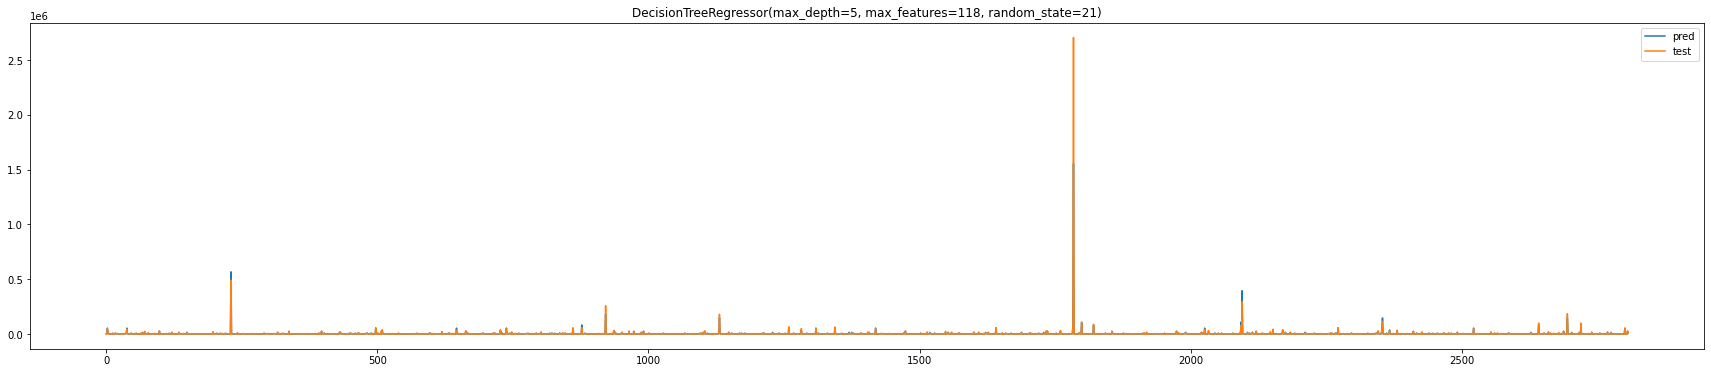

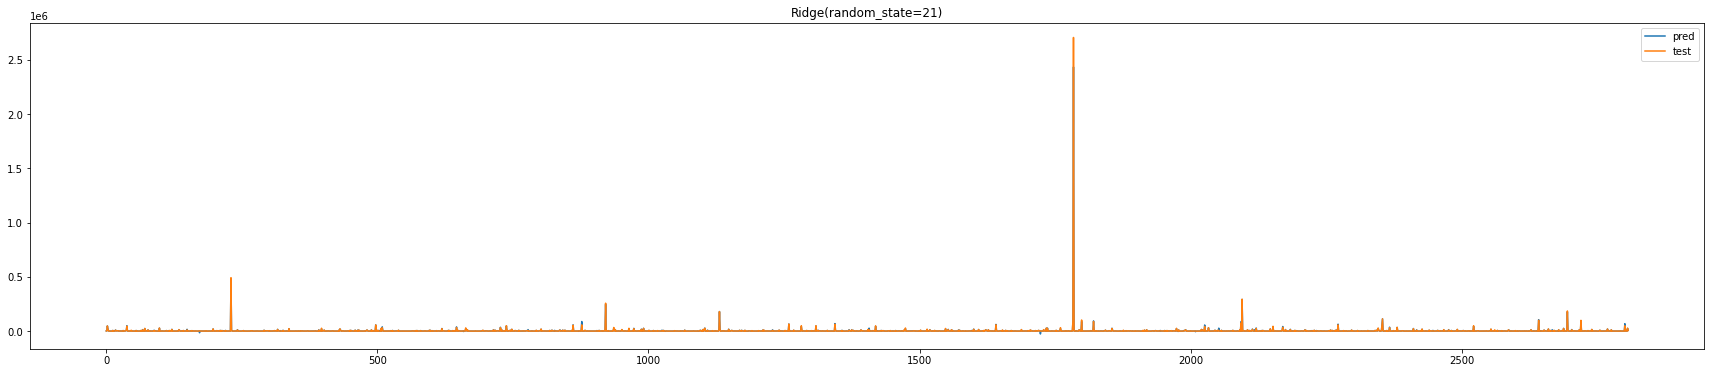

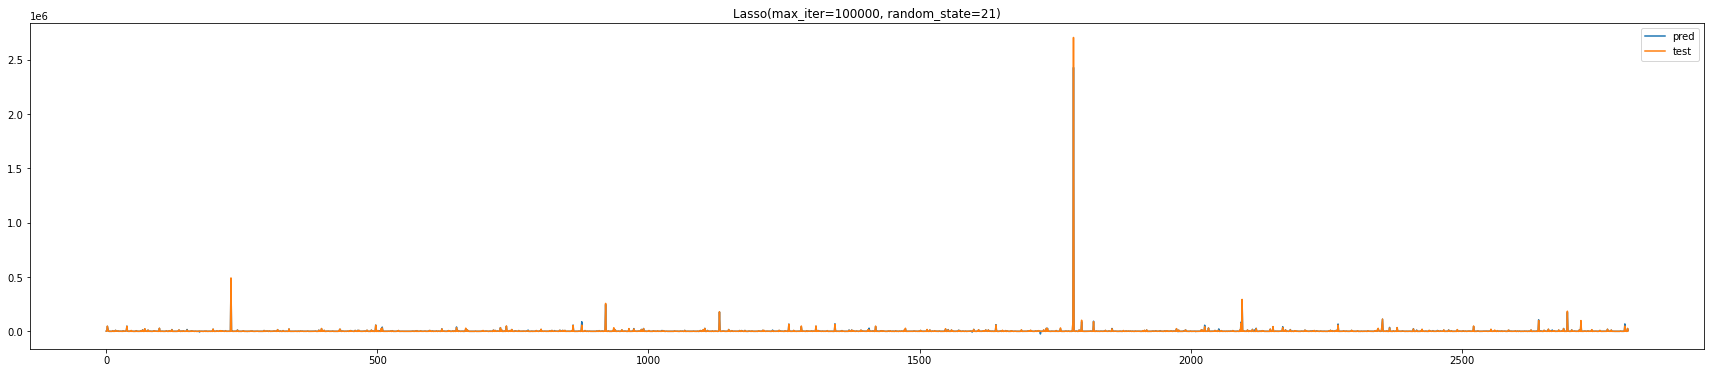

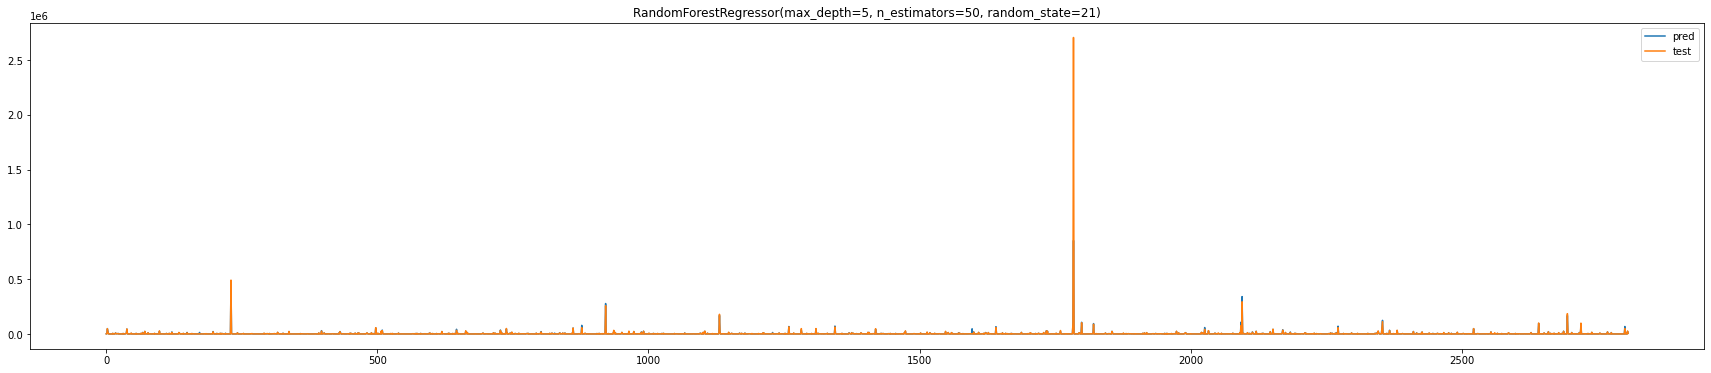

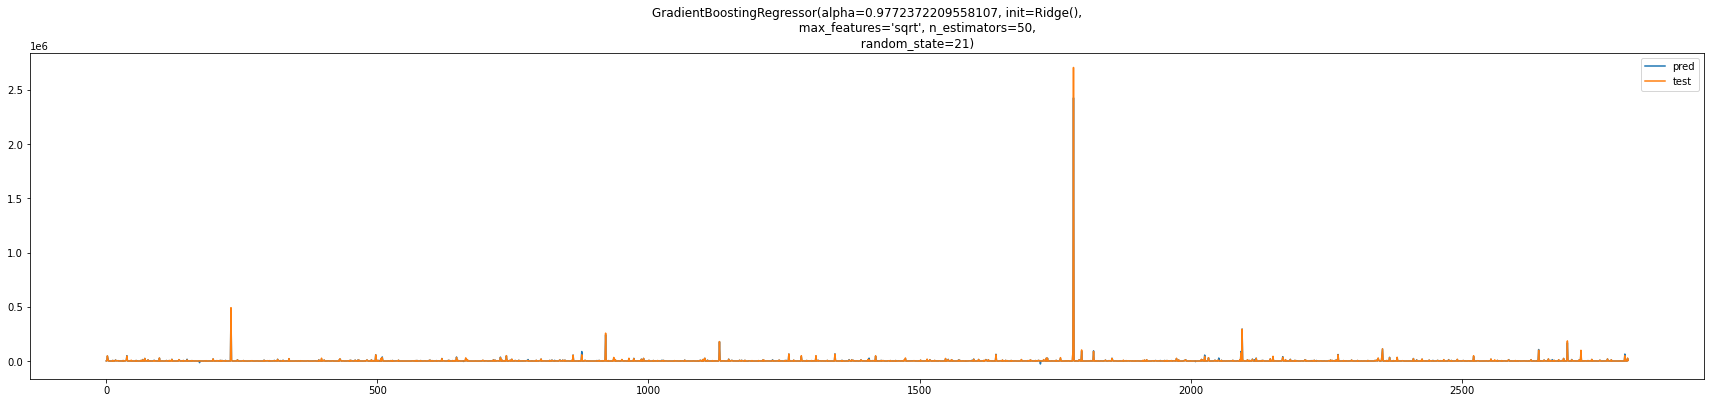

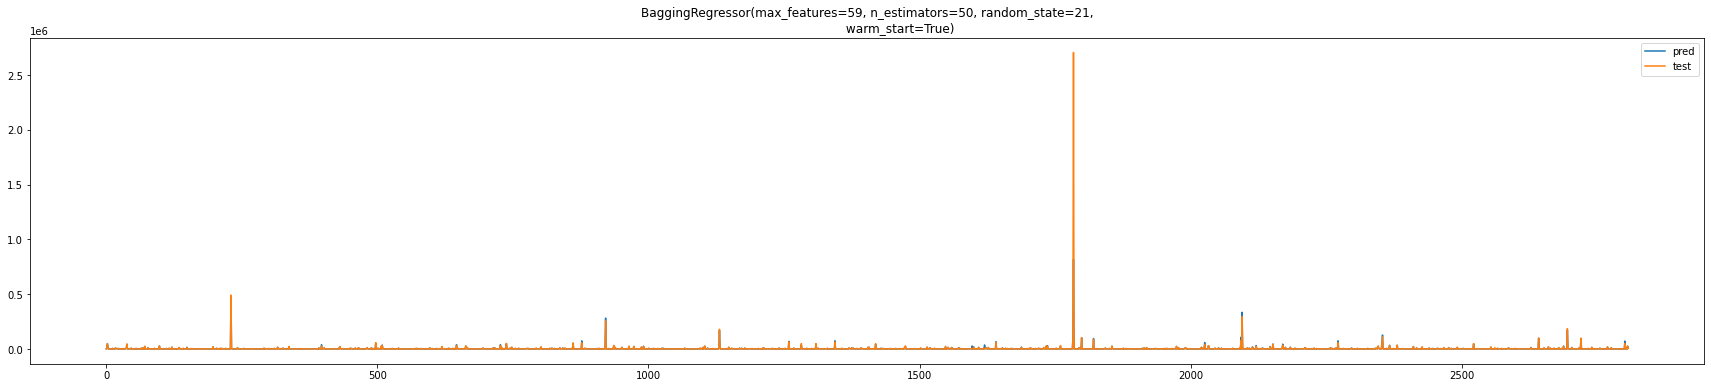

Learning rate set to 0.057334
0:	learn: 27879.1453015	total: 65.4ms	remaining: 1m 5s
1:	learn: 27083.2421279	total: 94.9ms	remaining: 47.4s
2:	learn: 26320.1752758	total: 124ms	remaining: 41.3s
3:	learn: 25602.1452221	total: 159ms	remaining: 39.7s
4:	learn: 24898.1270895	total: 195ms	remaining: 38.9s
5:	learn: 24208.8774943	total: 231ms	remaining: 38.2s
6:	learn: 23561.9730130	total: 261ms	remaining: 37s
7:	learn: 22946.5452762	total: 290ms	remaining: 35.9s
8:	learn: 22363.5952126	total: 320ms	remaining: 35.2s
9:	learn: 21792.5207206	total: 349ms	remaining: 34.5s
10:	learn: 21252.9981191	total: 378ms	remaining: 33.9s
11:	learn: 20735.6108854	total: 407ms	remaining: 33.5s
12:	learn: 20252.4697242	total: 441ms	remaining: 33.5s
13:	learn: 19774.3935458	total: 471ms	remaining: 33.2s
14:	learn: 19310.5973090	total: 502ms	remaining: 33s
15:	learn: 18831.7237213	total: 535ms	remaining: 32.9s
16:	learn: 18405.4967692	total: 569ms	remaining: 32.9s
17:	learn: 18016.5169282	total: 598ms	remaining

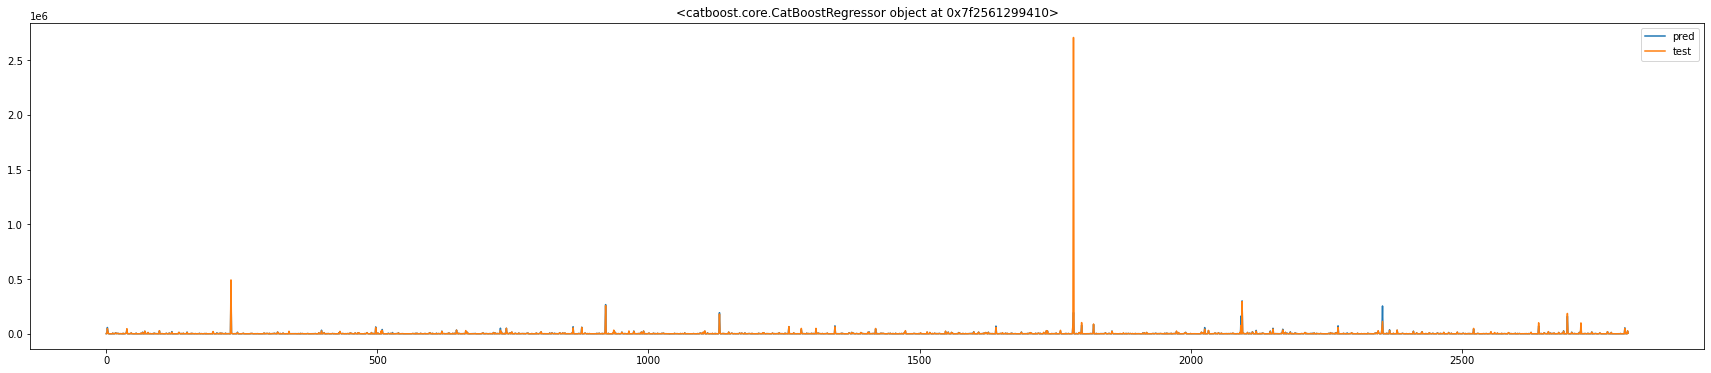

In [62]:
preds = []

for i, model in enumerate(models):
    MSE, R2, fin, pred = testing(model, X_train.fillna(X_train.mean()), y_train, X_test.fillna(X_test.mean()), y_test)
    ans.iloc[i]['MSE'] = MSE
    ans.iloc[i]['R2'] = R2
    ans.iloc[i]['Time'] = fin
    preds.append(pred)

In [63]:
ans

,MSE,R2,Time
DecisionTree,485325413.266952,0.561299,0.594215
Ridge,29061455.696095,0.987441,0.03413
Lasso,29811592.741856,0.98706,4.79122
RandomForest,1226885607.144525,-1.555214,12.932426
GradientBoosting,30751131.955833,0.986621,1.168841
Bagging,1274572688.766339,-1.765441,23.362405
CatBoost,2263271476.537768,-9.287049,33.639749


In [74]:
best_preds = [preds[1], preds[2], preds[4], preds[0]]
i = 0
while i < 4:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('MSE', mean_squared_error(curr_pred, y_test))
    print('R2', r2_score(curr_pred, y_test))
    print()
    i += 1

0
MSE 29061455.696094844
R2 0.9874408830537842

1
MSE 29388492.89537332
R2 0.9872715673273655

2
MSE 29797287.229424972
R2 0.9870747019463779

3
MSE 90074278.47091042
R2 0.9538552000156617



Попробуем добавить к временному ряду другие признаки